In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite", echo=False) # Set echo=True to see the actual SQL statements

In [5]:
# reflect an existing database into a new model
# Declare a Base using `automap_base()`
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
min_max_avg = calc_temps('2016-08-01', '2016-08-07') 
avg_temp =  min_max_avg[0][1]
min_temp =  min_max_avg[0][0]
max_temp =  min_max_avg[0][2]
ptp = max_temp - min_temp
print(avg_temp, min_temp, max_temp, ptp)

77.79545454545455 72.0 83.0 11.0


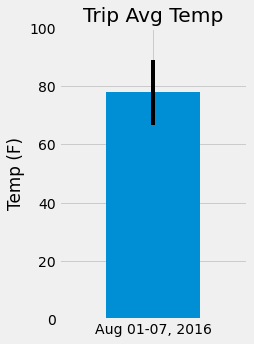

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df = pd.DataFrame([avg_temp], index =['Aug 01-07, 2016'], columns =['Trip Avg Temp'])
df.plot.bar(legend=False, rot=0, title='Trip Avg Temp', yerr=ptp, figsize=(3,5), ylim=(0,100))
plt.ylabel("Temp (F)")
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = dt.datetime(2016, 8, 1)
end_date   = dt.datetime(2016, 8, 7)

result = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp).label('total_prcp')).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    group_by(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    order_by(func.sum(Measurement.prcp).desc()).all()

for station in result:
    print(station.total_prcp, station.station, station.name, station.latitude, station.longitude, station.elevation)
    

2.49 USC00519281 WAIHEE 837.5, HI US 21.45167 -157.84888999999998 32.9
2.44 USC00516128 MANOA LYON ARBO 785.2, HI US 21.3331 -157.8025 152.4
1.24 USC00513117 KANEOHE 838.1, HI US 21.4234 -157.8015 14.6
1.03 USC00514830 KUALOA RANCH HEADQUARTERS 886.9, HI US 21.5213 -157.8374 7.0
0.76 USC00519523 WAIMANALO EXPERIMENTAL FARM, HI US 21.33556 -157.71139 19.5
0.49 USC00519397 WAIKIKI 717.2, HI US 21.2716 -157.8168 3.0
0.18 USC00517948 PEARL CITY, HI US 21.3934 -157.9751 11.9


In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [19]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_date, end_date).tolist()

# Strip off the year and save a list of strings in the format %m-%d
md_strings = []
for the_date in trip_dates:
    md_strings.append(dt.datetime.strftime(the_date, '%m-%d'))

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for month_day in md_strings:
    normals.append(daily_normals(month_day)[0])

#Extract the min, avg, max values from the normals list into individual arrays.
#This will help to create the area plot.

min = []
max = []
avg = []

for the_normal in normals:
        min.append(the_normal[0])
        avg.append(the_normal[1])
        max.append(the_normal[2])

normal_dict = {}
normal_dict["Min"] = min;
normal_dict["Avg"] = avg;
normal_dict["Max"] = max;

In [20]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame( normal_dict, index=trip_dates)
df

,Min,Avg,Max
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


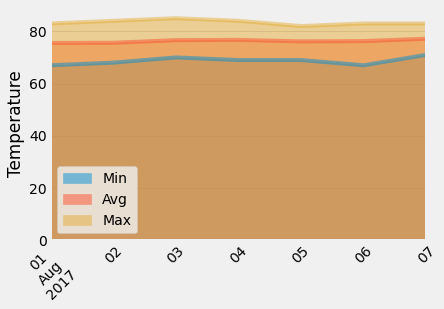

In [21]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked = False, rot=45)
plt.ylabel('Temperature')
plt.show()

## Close Session

In [22]:
session.close()